In [1]:
import pylab
import numpy as np
import json
import networkx as nx
import random
import copy
import os

# useful additional packages
import numpy as np
import networkx as nx
import seaborn as sns
import time
import argparse
import mlflow

# Qiskit Imports
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA, NELDER_MEAD

# Custom Imports
from qaoa_vrp.features.graph_features import *
from qaoa_vrp.exp_utils import str2bool, make_temp_directory, to_snake_case
from qaoa_vrp.generators.graph_instance import GraphInstance
from qaoa_vrp.plot.draw_networks import draw_graph

In [2]:
# Number of nodes
N = 10
# Max iterations
MAX_ITERATIONS = 1000
# Number of restarts
N_RESTARTS = 1
track_mlflow = False

# Create a 3-regular graph (based on https://arxiv.org/pdf/2106.10055.pdf)
G_three_regular = GraphInstance(
    nx.random_regular_graph(d=3, n=N), graph_type="3-Regular Graph"
)


G_three_regular

This is a 3-Regular Graph Graph with 10 nodes and 15 edges graph instance

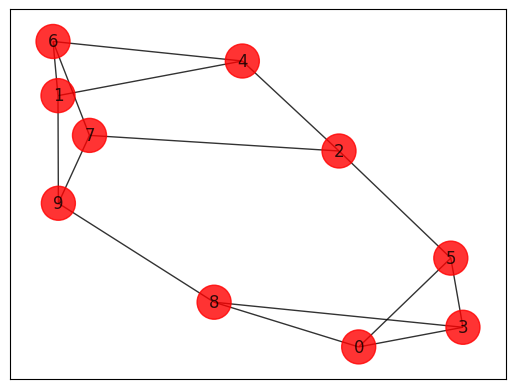

In [3]:
draw_graph(G_three_regular.G)

In [4]:
print(f"Solving Brute Force for {G_three_regular.graph_type}\n{'-'*50}\n")
G = G_three_regular.G

print(G_three_regular)
G_three_regular.allocate_random_weights()
G_three_regular.compute_weight_matrix()

Solving Brute Force for 3-Regular Graph
--------------------------------------------------

This is a 3-Regular Graph Graph with 10 nodes and 15 edges graph instance


In [5]:
print(G_three_regular.weight_matrix)

[[0. 0. 0. 4. 0. 6. 0. 0. 3. 0.]
 [0. 0. 0. 0. 8. 0. 5. 0. 0. 6.]
 [0. 0. 0. 0. 4. 3. 0. 4. 0. 0.]
 [4. 0. 0. 0. 0. 5. 0. 0. 8. 0.]
 [0. 8. 4. 0. 0. 0. 8. 0. 0. 0.]
 [6. 0. 3. 5. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 8. 0. 0. 9. 0. 0.]
 [0. 0. 4. 0. 0. 0. 9. 0. 0. 0.]
 [3. 0. 0. 8. 0. 0. 0. 0. 0. 8.]
 [0. 6. 0. 0. 0. 0. 0. 0. 8. 0.]]


In [6]:
G = G_three_regular.G
w = G_three_regular.weight_matrix
n = len(G.nodes())

In [7]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]

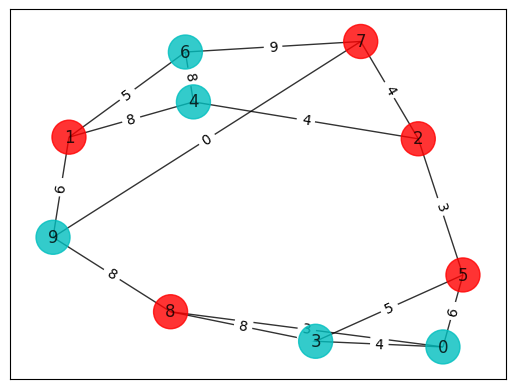

In [8]:
draw_graph(G, colors=colors)

In [9]:
max_cut = Maxcut(G_three_regular.weight_matrix)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -8*x_0*x_3 - 12*x_0*x_5 - 6*x_0*x_8 - 16*x_1*x_4 - 10*x_1*x_6 - 12*x_1*x_9
  - 8*x_2*x_4 - 6*x_2*x_5 - 8*x_2*x_7 - 10*x_3*x_5 - 16*x_3*x_8 - 16*x_4*x_6
  - 18*x_6*x_7 - 16*x_8*x_9 + 13*x_0 + 19*x_1 + 11*x_2 + 17*x_3 + 20*x_4
  + 14*x_5 + 22*x_6 + 13*x_7 + 19*x_8 + 14*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9



In [10]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -40.5
Ising Hamiltonian:
2.0 * IIIIIIZIIZ
+ 4.0 * IIIIIZIIZI
+ 2.0 * IIIIIZIZII
+ 3.0 * IIIIZIIIIZ
+ 1.5 * IIIIZIIZII
+ 2.5 * IIIIZIZIII
+ 2.5 * IIIZIIIIZI
+ 4.0 * IIIZIZIIII
+ 2.0 * IIZIIIIZII
+ 4.5 * IIZZIIIIII
+ 1.5 * IZIIIIIIIZ
+ 4.0 * IZIIIIZIII
+ 3.0 * ZIIIIIIIZI
+ 4.0 * ZZIIIIIIII


In [11]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print("\nBest solution BRUTE FORCE = "
    + str(xbest_brute)
    + " cost = "
    + str(best_cost_brute)
)


Best solution BRUTE FORCE = [0, 1, 1, 0, 0, 1, 1, 0, 1, 0] cost = 69.0


In [12]:
print(f"\n{'-'*10} Checking that current Hamiltonian gives right cost {'-'*10}\n")


---------- Checking that current Hamiltonian gives right cost ----------



In [13]:
ee = NumPyMinimumEigensolver()

# Calculate the min eigenvalue
optimal_result = ee.compute_minimum_eigenvalue(qubitOp)

ground_state = max_cut.sample_most_likely(optimal_result.eigenstate)
print("ground state energy:", optimal_result.eigenvalue.real)
print("optimal max-cut objective:", optimal_result.eigenvalue.real + offset)
print("ground state solution:", ground_state)
print("ground state objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]


ground state energy: -28.5
optimal max-cut objective: -69.0
ground state solution: [1 0 1 1 0 0 1 0 0 1]
ground state objective: 0.0


In [14]:
print(f"\n{'-'*10} Simulating Instance on Quantum using VQE {'-'*10}\n")

# Run optimisation code
optimizer = COBYLA(maxiter=MAX_ITERATIONS)
num_qubits = qubitOp.num_qubits

init_state = np.random.rand(num_qubits) * 2 * np.pi
optimizer_results = []

result = {"algo": None, "result": None}

## Setting parameters for a run (Simulator Backend etc)
algorithm_globals.random_seed = 12321
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed
)

print(f"The initial state is {init_state}")
print(f"Testing Optimizer {type(optimizer).__name__}")


---------- Simulating Instance on Quantum using VQE ----------

The initial state is [1.9582353  4.76851936 0.86125813 0.52219743 1.19778199 2.99496085
 0.22914753 0.28015049 6.17392587 2.94768899]
Testing Optimizer COBYLA


Running Optimization at n_restart=0
COBYLA iteration 100 	 cost function -22.330907878196694
COBYLA iteration 200 	 cost function -27.292792717359333
COBYLA iteration 300 	 cost function -28.183111525410997
COBYLA iteration 400 	 cost function -28.410472669452755
COBYLA iteration 500 	 cost function -28.476551528161785
COBYLA iteration 600 	 cost function -28.491027941195046
COBYLA iteration 700 	 cost function -28.496368835694938
COBYLA iteration 800 	 cost function -28.49815926754679
COBYLA iteration 900 	 cost function -28.499060466864574
COBYLA iteration 1000 	 cost function -28.499670334447
COBYLA iteration 100 	 cost function -8.030217605120527
COBYLA iteration 200 	 cost function -8.033440911416502

---------- Optimization Complete ----------



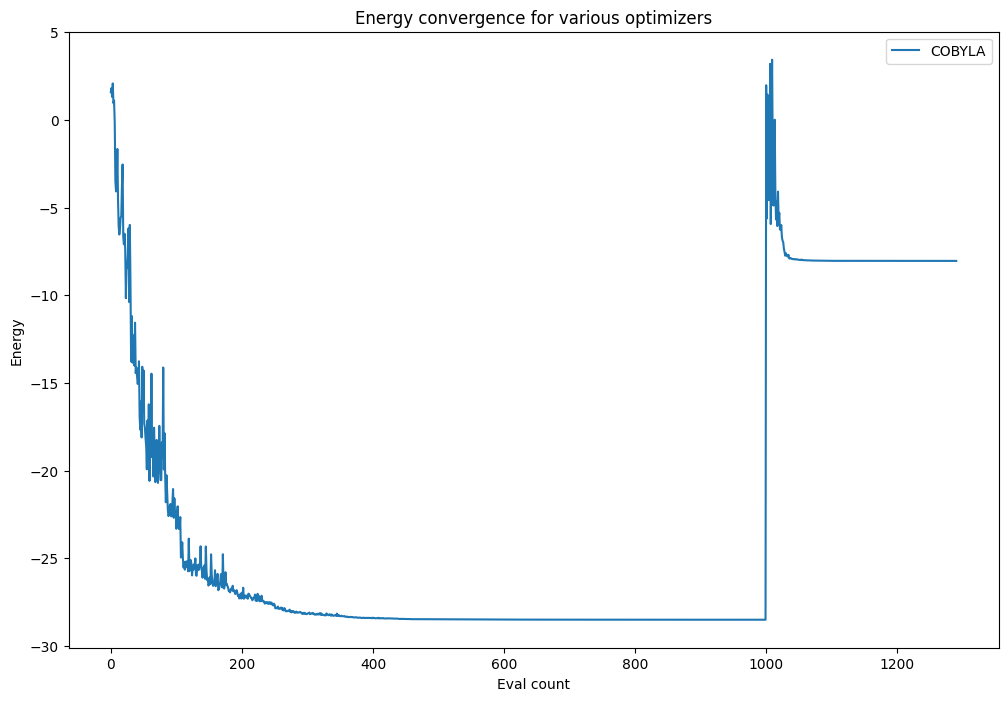

In [35]:
counts = []
values = []
algo = []

def store_intermediate_result(eval_count, parameters, mean, std):
    if track_mlflow:
        mlflow.log_metric(f"energy_{instance_type_logging}", mean)
    if eval_count % 100 == 0:
        print(
            f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}"
        )
    counts.append(eval_count)
    values.append(mean)

for restart in range(N_RESTARTS):
    print(f"Running Optimization at n_restart={restart}")
    init_state = np.random.rand(4) * 2 * np.pi

    # Define the systems of rotation for x and y
    ry = TwoLocal(num_qubits, "ry", "cz", reps=2, entanglement="linear")

    # VQE definition
    vqe = VQE(
        ry,
        optimizer=optimizer,
        quantum_instance=quantum_instance,
        callback=store_intermediate_result,
    )
    
    # QAOA definition
    qaoa = QAOA(
        optimizer=optimizer, 
        reps=2, 
        initial_point=init_state, 
        callback=store_intermediate_result, 
        quantum_instance=quantum_instance
    )
    

    vqe_result = vqe.compute_minimum_eigenvalue(qubitOp)
    qaoa_result = qaoa.compute_minimum_eigenvalue(qubitOp)

# Convergence array
total_counts = np.arange(0, len(counts))
values = np.asarray(values)

print(f"\n{'-'*10} Optimization Complete {'-'*10}\n")

pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(total_counts, values, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right")

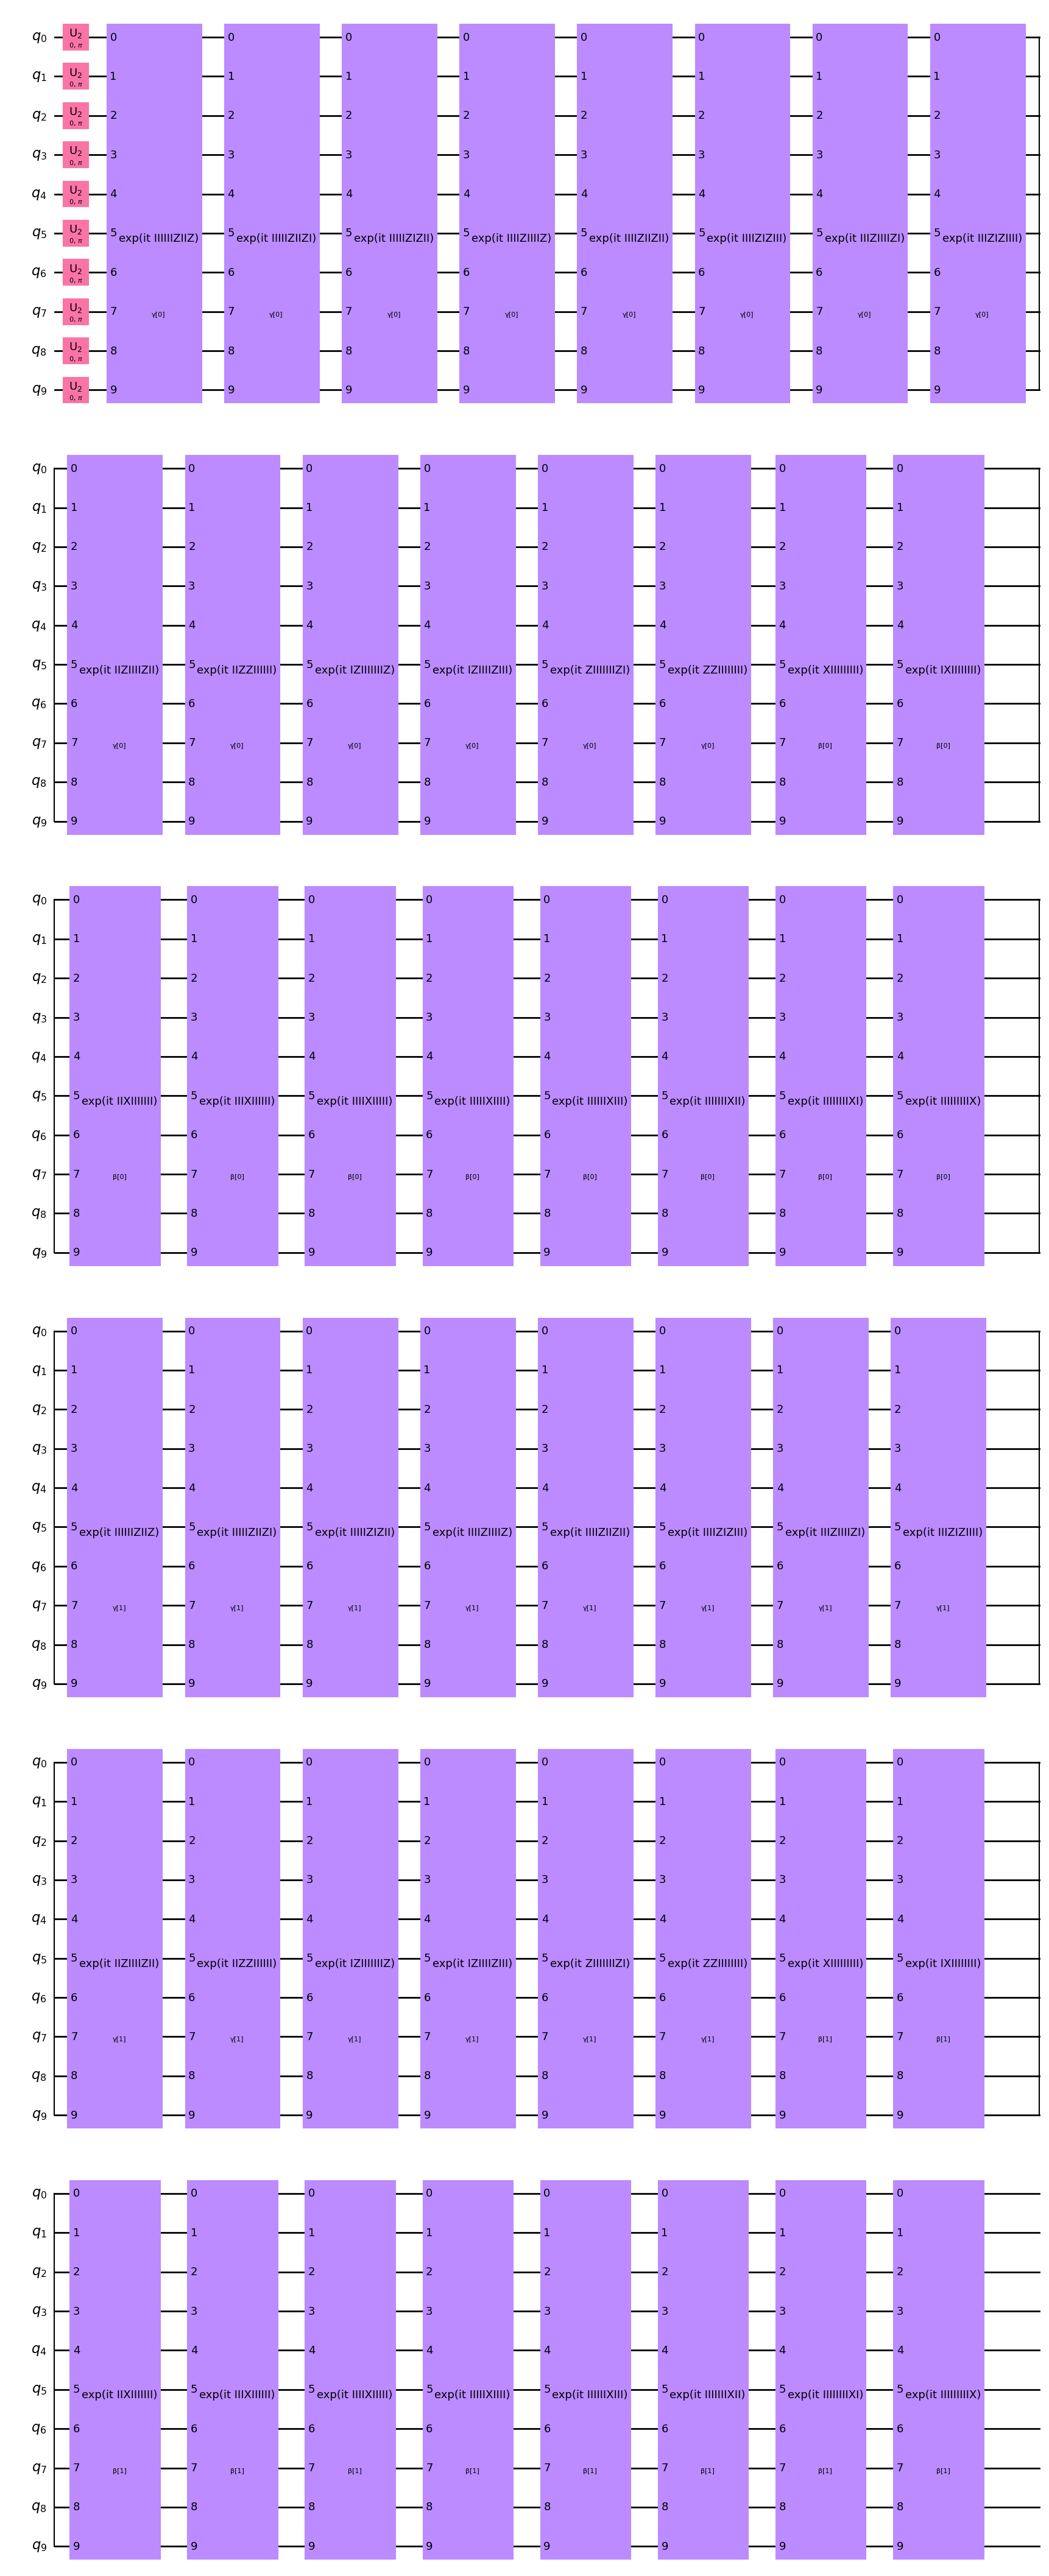

In [16]:
qaoa.ansatz.decompose().draw('mpl')

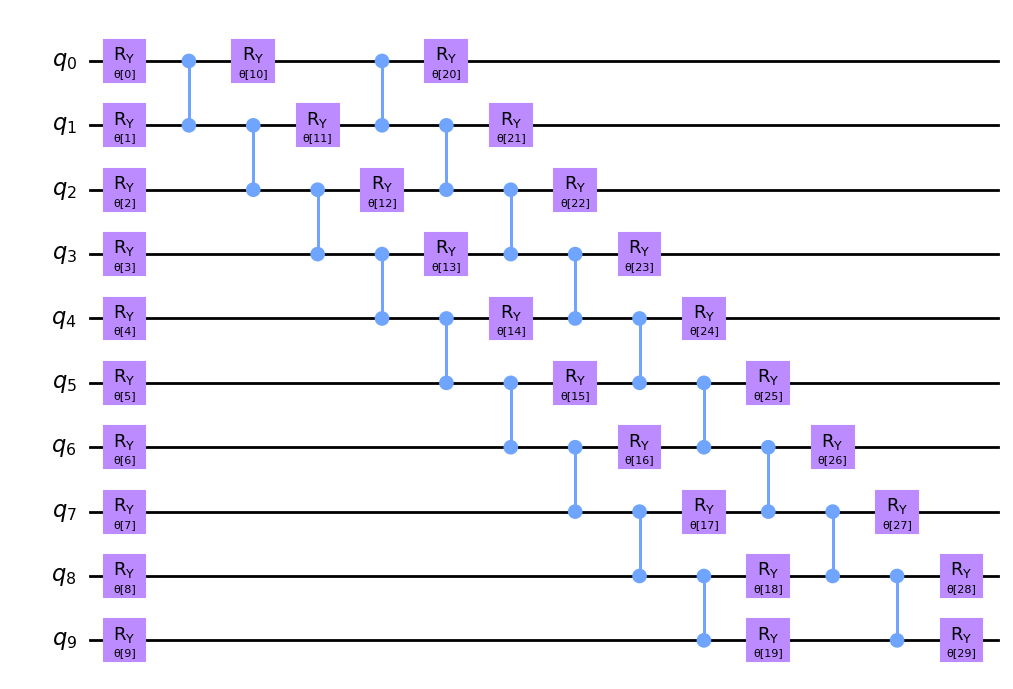

In [17]:
vqe.ansatz.decompose().draw('mpl')

## Filter VQE Circuit

In [18]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import ParameterVector
from scipy.optimize import minimize


In [19]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_filter_vqe_circ(G, theta):
    """
    Creates a parametrized F-VQE circuit
    
    Args:  
        G: networkx graph
                     
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())
#    theta = ParameterVector("$\\theta$", (2*nqubits - 1))
    p = 1
    qc = QuantumCircuit(nqubits)
    for i in range(0, N):
        qc.ry(theta[i], i)

    for i in range(0, N):
        if i < (N-1):
            qc.cnot(i,i+1)
    for i in range(0, N):
        qc.ry(theta[i+9], i)
        
    # Measure across qubits
    qc.measure_all()
    
    return qc

def create_vqe_circ(G, theta):
    nqubits = len(G.nodes())
    ry = TwoLocal(nqubits, "ry", "cz", reps=2, entanglement="linear")

    # Get backend
    backend = Aer.get_backend("aer_simulator_statevector")
    quantum_instance = QuantumInstance(backend)

    # VQE definition
    vqe = VQE(
        ry,
        optimizer=COBYLA,
        quantum_instance=quantum_instance,
        callback=store_intermediate_result,
    )
    
    qc = vqe.ansatz.decompose()
    theta = np.random.random(len(qc.parameters))
    qc = qc.bind_parameters(theta)
    
    qc.measure_all()
    
    return qc
    

def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
    
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512, algorithm="fvqe"):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
        algorithm: 'fvqe', 'vqe', 'qaoa'
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    def execute_circ(theta):
        
        if algorithm == "qaoa":
            qc = create_qaoa_circ(G, theta)
        elif algorithm == "fvqe":
            qc = create_filter_vqe_circ(G, theta)
        elif algorithm == "vqe":
            qc = create_vqe_circ(G, theta)
        
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


In [20]:
expectation = get_expectation(G, algorithm="qaoa")
res = minimize(
    expectation, 
    np.random.random(2), 
    method='COBYLA', 
    options={"maxiter":1000,"disp":True, "rhobeg":0.001},
    
)
res

     fun: -7.2109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([0.84973894, 0.93196759])

   Normal return from subroutine COBYLA

   NFVALS =   13   F =-7.210938E+00    MAXCV = 0.000000E+00
   X = 8.497389E-01   9.319676E-01


In [21]:
expectation = get_expectation(G, algorithm="qaoa")
res = minimize(
    expectation, 
    np.random.random(2), 
    method='COBYLA', 
    options={"maxiter":1000,"disp":True, "rhobeg":0.001},
    
)
res


   Normal return from subroutine COBYLA

   NFVALS =   15   F =-7.367188E+00    MAXCV = 0.000000E+00
   X = 3.520527E-01   8.608920E-01


     fun: -7.3671875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 15
  status: 1
 success: True
       x: array([0.35205272, 0.86089203])

In [22]:
n_qubits=9
layers = 1
def add_fqe_layer(qc, layer_num):
    qc.barrier()
    i = 1
    # Add case for when odd number of qubits
    if qc.num_qubits % 2 == 1:
        while i < qc.num_qubits:
            if i % 2 == 1:
                qc.cnot(i-1, i)
            fvqe_rot_param = Parameter(f'fvqe_a_{layer_num}_q[{i}]')
            qc.ry(fvqe_rot_param,i-1)
            i += 1
        # Add second row of CNOTs and RY rotations
        i = 1
        while i <= qc.num_qubits:
            if i % 2 == 0:
                qc.cnot(i-1, i)
            if i != 1:
                fvqe_rot_param_b = Parameter(f'fvqe_b_{layer_num}_q[{i}]') 
                qc.ry(fvqe_rot_param_b,i-1)
            i += 1
    if qc.num_qubits % 2 == 0:
        while i < qc.num_qubits:
            if i % 2 == 1:
                qc.cnot(i-1, i)
            fvqe_rot_param = Parameter(f'fvqe_a_{layer_num}_q[{i}]')
            qc.ry(fvqe_rot_param,i-1)
            i += 1

        i = 1
        while i <= qc.num_qubits:
            if i % 2 == 0 and i != qc.num_qubits:
                qc.cnot(i-1, i)
            if i != 1 and i != qc.num_qubits:
                fvqe_rot_param_b = Parameter(f'fvqe_b_{layer_num}_q[{i}]') 
                qc.ry(fvqe_rot_param_b,i-1)
            i += 1

    return qc


def create_base_f_vqe_circuit(G, theta=None, layers=1):
    
    # Create Quantum Circuit
    n_qubits = len(G.nodes())
    qc = QuantumCircuit(n_qubits)
    initial_rot_params = ParameterVector('a', n_qubits)
    for i in range(n_qubits):
        qc.ry(initial_rot_params[i], i)
    
    # Add F-VQE Layer
    for i in range(layers):
        qc = add_fqe_layer(qc, i)
    
    # Add final barrier
    qc.barrier()
    
    if theta is not None:
        qc.assign_parameters(parameters=theta)
    return qc

In [25]:
qc = create_base_f_vqe_circuit(G,layers=2)

NameError: name 'Parameter' is not defined

In [26]:
qc.draw('mpl')

NameError: name 'qc' is not defined

In [27]:
last_qubit_params = {f'qubit_param_{i}':'' for i in range(qc.num_qubits)}
for qubit in qc.qubits:
    for data in qc.data:
        if data.operation.name == "ry" and data.qubits[0] == qubit:
            last_qubit_params[f'qubit_param_{qubit.index}'] = data.operation.params[0].name

initial_point = [np.pi/2 if param.name in last_qubit_params.values() else 0 for param in qc.parameters]
initial_point

NameError: name 'qc' is not defined

In [28]:
qc.draw('mpl')

NameError: name 'qc' is not defined

In [29]:
# #Run the circuit with assigned parameters on Aer's statevector simulator
# from qiskit.visualization import plot_state_city
# simulator = Aer.get_backend('statevector_simulator')
# result = simulator.run(qc).result()
# statevector = result.get_statevector(qc)
# statevector

In [30]:
qc = qc.assign_parameters(parameters=initial_point)
qc.draw('mpl')

NameError: name 'qc' is not defined

In [31]:
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_base_f_vqe_circuit(G, theta)
        import pdb; pdb.set_trace()
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()

        return compute_expectation(counts, G)
    
    return execute_circ

In [32]:
from scipy.optimize import minimize


expectation = get_expectation(G)

res = minimize(expectation, 
                      initial_point, 
                      method='COBYLA')
res

NameError: name 'initial_point' is not defined

In [33]:
# Approximation ratio
# take objective function vs random solution
# randomnly a select a CUT and then find the energy 
# find a definition on how 